<div style="background-color:#f0f8ff; padding:15px; border-radius:8px; font-size:16px; line-height:1.6;">
  <h3 style="margin-top:0;">Author: Nikolin Prenga</h3>
  <p><strong>Created:</strong> July 2025</p>

  <p>
    This Jupyter notebook performs inference using two trained YOLO models (<strong>version 11</strong> and <strong>version 12</strong>)
    on custom-annotated brain tumor image data.
  </p>

  <p>
    The models detect and classify tumors into four categories:
    <em>Glioma tumor</em> (0), <em>Meningioma tumor</em> (1), <em>Pituitary tumor</em> (2), and <em>No tumor</em> (3).
  </p>

  <p>
    Class predictions are converted to tumor type labels, and bounding boxes are drawn on the images
    with corresponding confidence scores.
  </p>

  <p>
    The notebook also supports <strong>real-time inference on video data</strong>, allowing visual inspection of tumor detection frame by frame.
  </p>
</div>



In [2]:
import numpy as np
import cv2
import os   
import matplotlib.pyplot as plt
from PIL import Image
import shutil
import yaml
from ultralytics import YOLO

In [ ]:
# plot_boxes_classification is used to plot and classify the prediction
# As the model predicts results, for each image we extract bounding boxes, confidence scores, and class predictions
# Class predictions are mapped to tumor type names
# Bounding boxes are plotted with the confidence score and tumor name displayed
def plot_boxes_classification(results, ax):
    values = results[0]
    boxes = values.boxes
    class_id = boxes.cls.cpu().numpy().astype(int)
    confidences = boxes.conf.cpu().numpy()
    bboxes = boxes.xyxy.cpu().numpy()


    for cls, conf, bbox in zip(class_id, confidences, bboxes):
        if cls == 0:
            tumor_type = 'Glioma tumor'
        elif cls == 1:
            tumor_type = 'Meningioma tumor'
        elif cls == 2:
            tumor_type = 'Pituitary tumor'
        elif cls == 3:
            tumor_type = 'No tumor'
        else:
            tumor_type = 'Unknown tumor'

        x_min, y_min, x_max, y_max = bbox
        width = x_max - x_min
        height = y_max - y_min
        x_center = (x_min + x_max) / 2
        y_center = (y_min + y_max) / 2

        #ax.scatter([x_min, x_min + width], [y_min, y_min + height], color='red', s=20)
        #ax.scatter(x_center, y_center, color='green', s=20)
        ax.plot([x_min, x_min + width], [y_min, y_min], color='red', linewidth=2)
        ax.plot([x_min, x_min], [y_min, y_min + height], color='red', linewidth=2)
        ax.plot([x_min + width, x_min + width], [y_min, y_min + height], color='red', linewidth=2)
        ax.plot([x_min, x_min + width], [y_min + height, y_min + height], color='red',  linewidth=2)
        ax.text(x_min -width/4. , y_min - 11, f"{tumor_type} ({conf:.2f})",
                color='white', fontsize=10, bbox=dict(facecolor='magenta', alpha=0.5))

# In this part, predict_and_check takes a model, image path, mask path, a start index, and a stop index, usually 16
# From each image, we want to determine the true tumor type and compare it with the model's prediction
# Images are shuffled and loaded. The true tumor type is displayed on top, and the predictions are shown using plot_boxes_classification
def predict_and_check(model, image_path, mask_path, start, stop, mask=False):
    images_paths = os.listdir(image_path)
    np.random.shuffle(images_paths)
    images_paths = images_paths[start:stop]

    cols = 4
    rows = int(np.ceil(len(images_paths) / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(16, 4 * rows))

    for index, image_file in enumerate(images_paths):
        full_image_path = os.path.join(image_path, image_file)

        image = cv2.imread(full_image_path)
        if image is None:
            print(f"Image {full_image_path} could not be read. Skipping.")
            continue

        # Determine tumor type from filename
        if '_no_' in image_file:
            class_name = 'No tumor'
        elif '_gl_' in image_file:
            class_name = 'Glioma tumor'
        elif '_me_' in image_file:
            class_name = 'Meningioma tumor'
        elif '_pi_' in image_file:
            class_name = 'Pituitary tumor'
        else:
            class_name = 'Unknown'

        # Only load mask if mask=True and not a "no tumor" image
        if mask and class_name != 'No tumor':
            mask_path_full = os.path.join(mask_path, image_file)
            #mask = cv2.imread(mask_path_full, cv2.IMREAD_GRAYSCALE)
            loaded_mask = cv2.imread(mask_path_full, cv2.IMREAD_GRAYSCALE)

            if mask is None:
                print(f"Mask for {full_image_path} not found. Skipping.")
                continue
            # Overlay with mask
            mask_color = np.zeros_like(image)
            # mask_color[:, :, 0] = mask
            # overlay = cv2.addWeighted(image, 1.3, mask_color, 0.5, 0)

            mask_color[:, :, 0] = loaded_mask
            overlay = cv2.addWeighted(image, 1.3, mask_color, 0.5, 0)
        else:
            overlay = image  # No overlay if mask=False or no tumor

        # Run YOLO prediction
        result = model.predict(
            source=full_image_path,
            conf=0.25,
            save=False,
            imgsz=512,
            verbose=False
        )

        ax = axes.flat[index]
        ax.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
        plot_boxes_classification(result, ax)
        ax.set_title(f"Actual Image: {class_name}")
        ax.axis('off')

    # Turn off unused subplots
    for j in range(index + 1, len(axes.flat)):
        axes.flat[j].axis('off')

    plt.tight_layout()
    plt.show()



In [ ]:
# Load the trained YOLOv11 and YOLOv12 models from their respective checkpoint paths

best_model_v11_path = '/Users/nikolin/Desktop/Yolo V8-11/Second_Data_set/Last_one_v11_100epochs_small/runs/detect/brain_tumor_yolo/weights/best.pt'

best_model_v12_path='/Users/nikolin/Desktop/Yolo V8-11/First Try/YOLO_12_last_100epochs_small/runs/detect/brain_tumor_yolo/weights/best.pt'

best_model_v11 = YOLO(best_model_v11_path)

best_model_v12 = YOLO(best_model_v12_path)


In [ ]:
# Get the paths to the unseen test images and corresponding masks

image_path = 'Yolo_v11_Nikolin_Dataset/test/images'
mask_path = 'Yolo_v11_Nikolin_Dataset/test/masks'
start = 0
stop = 16

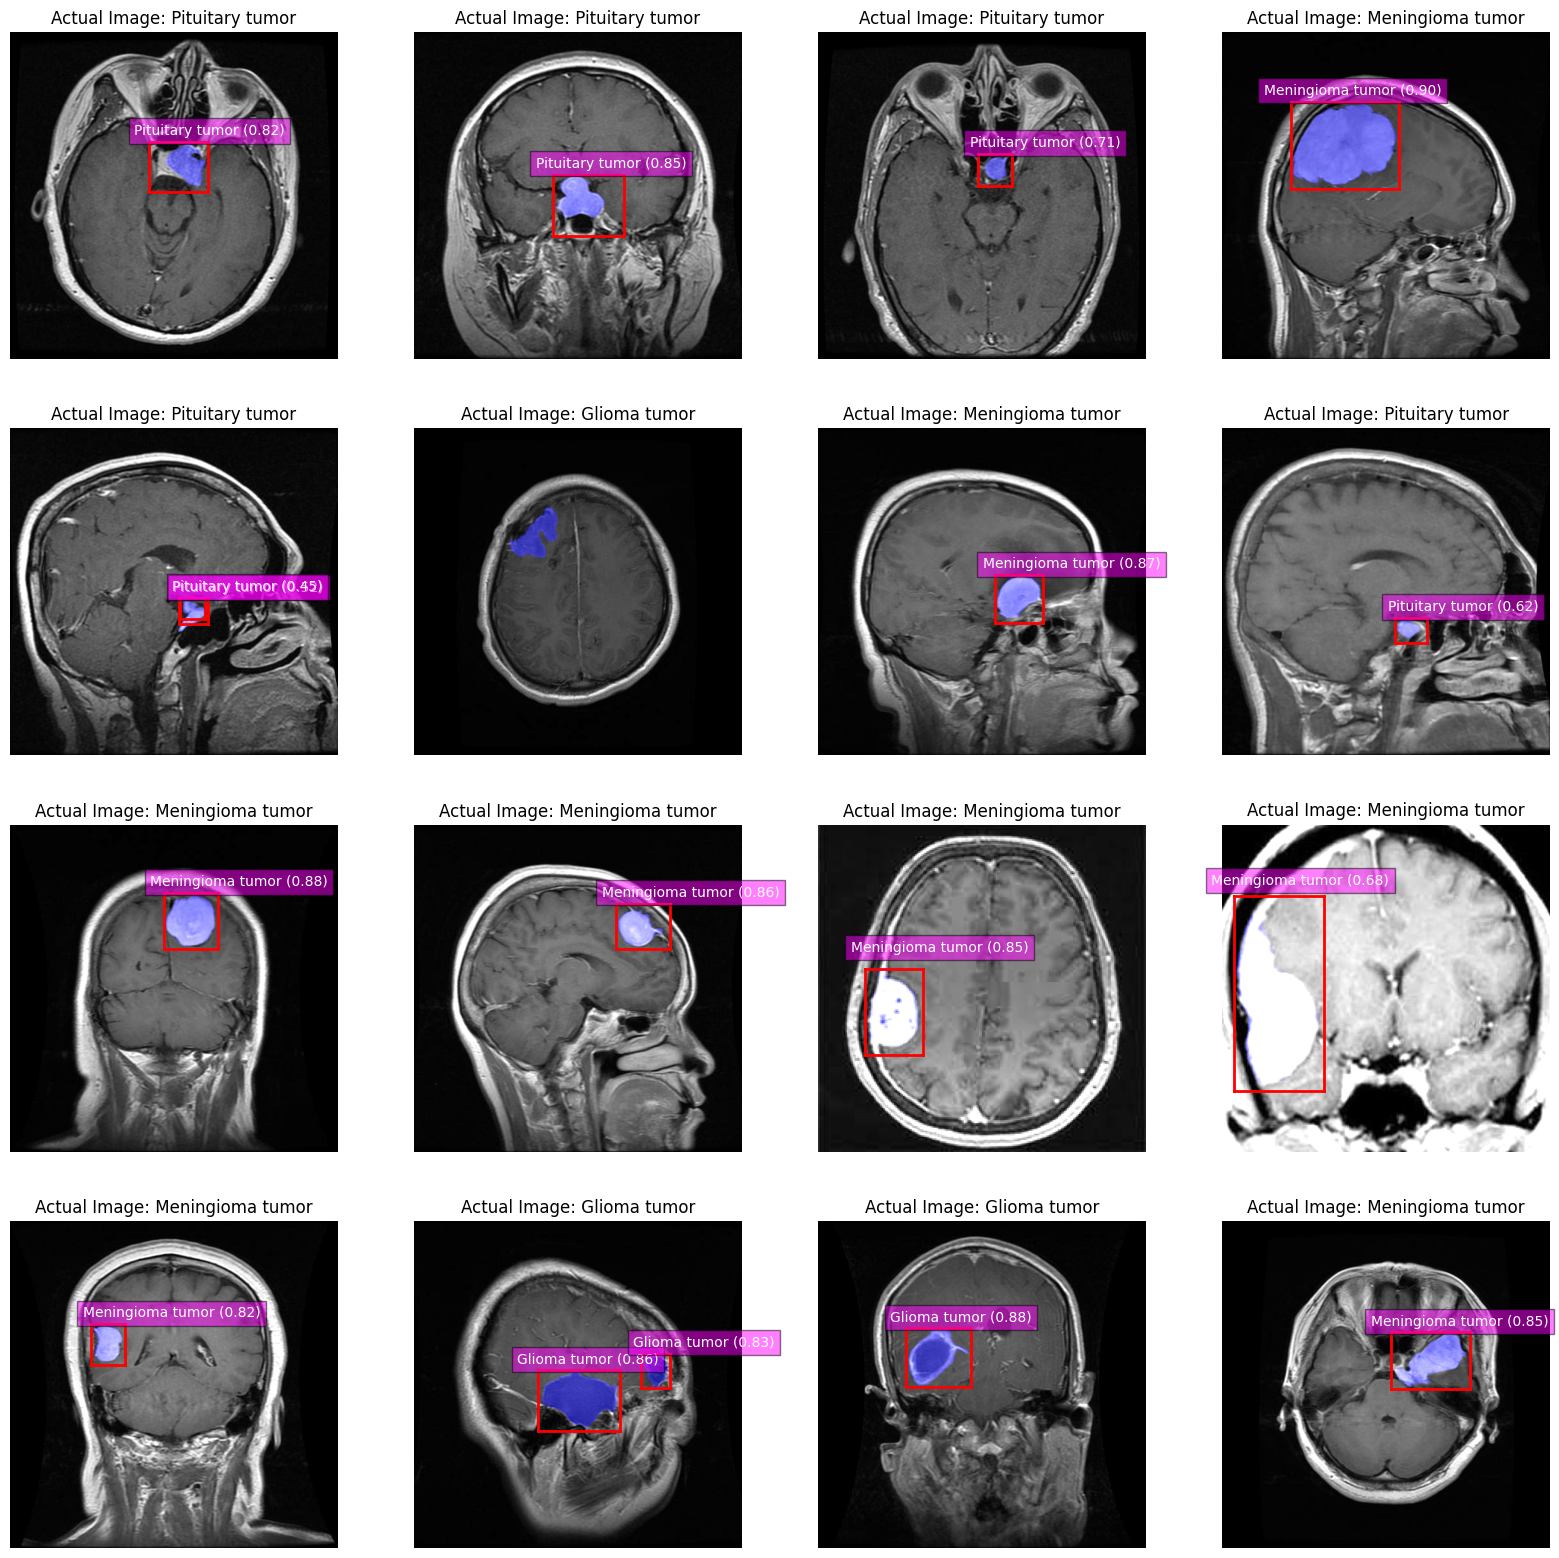

In [ ]:
# Run inference using the YOLOv11 model on a selected number of test images (with optional mask overlay)
predict_and_check(best_model_v11, image_path,
                        mask_path, 
                        start, 
                        stop,
                        mask=True)

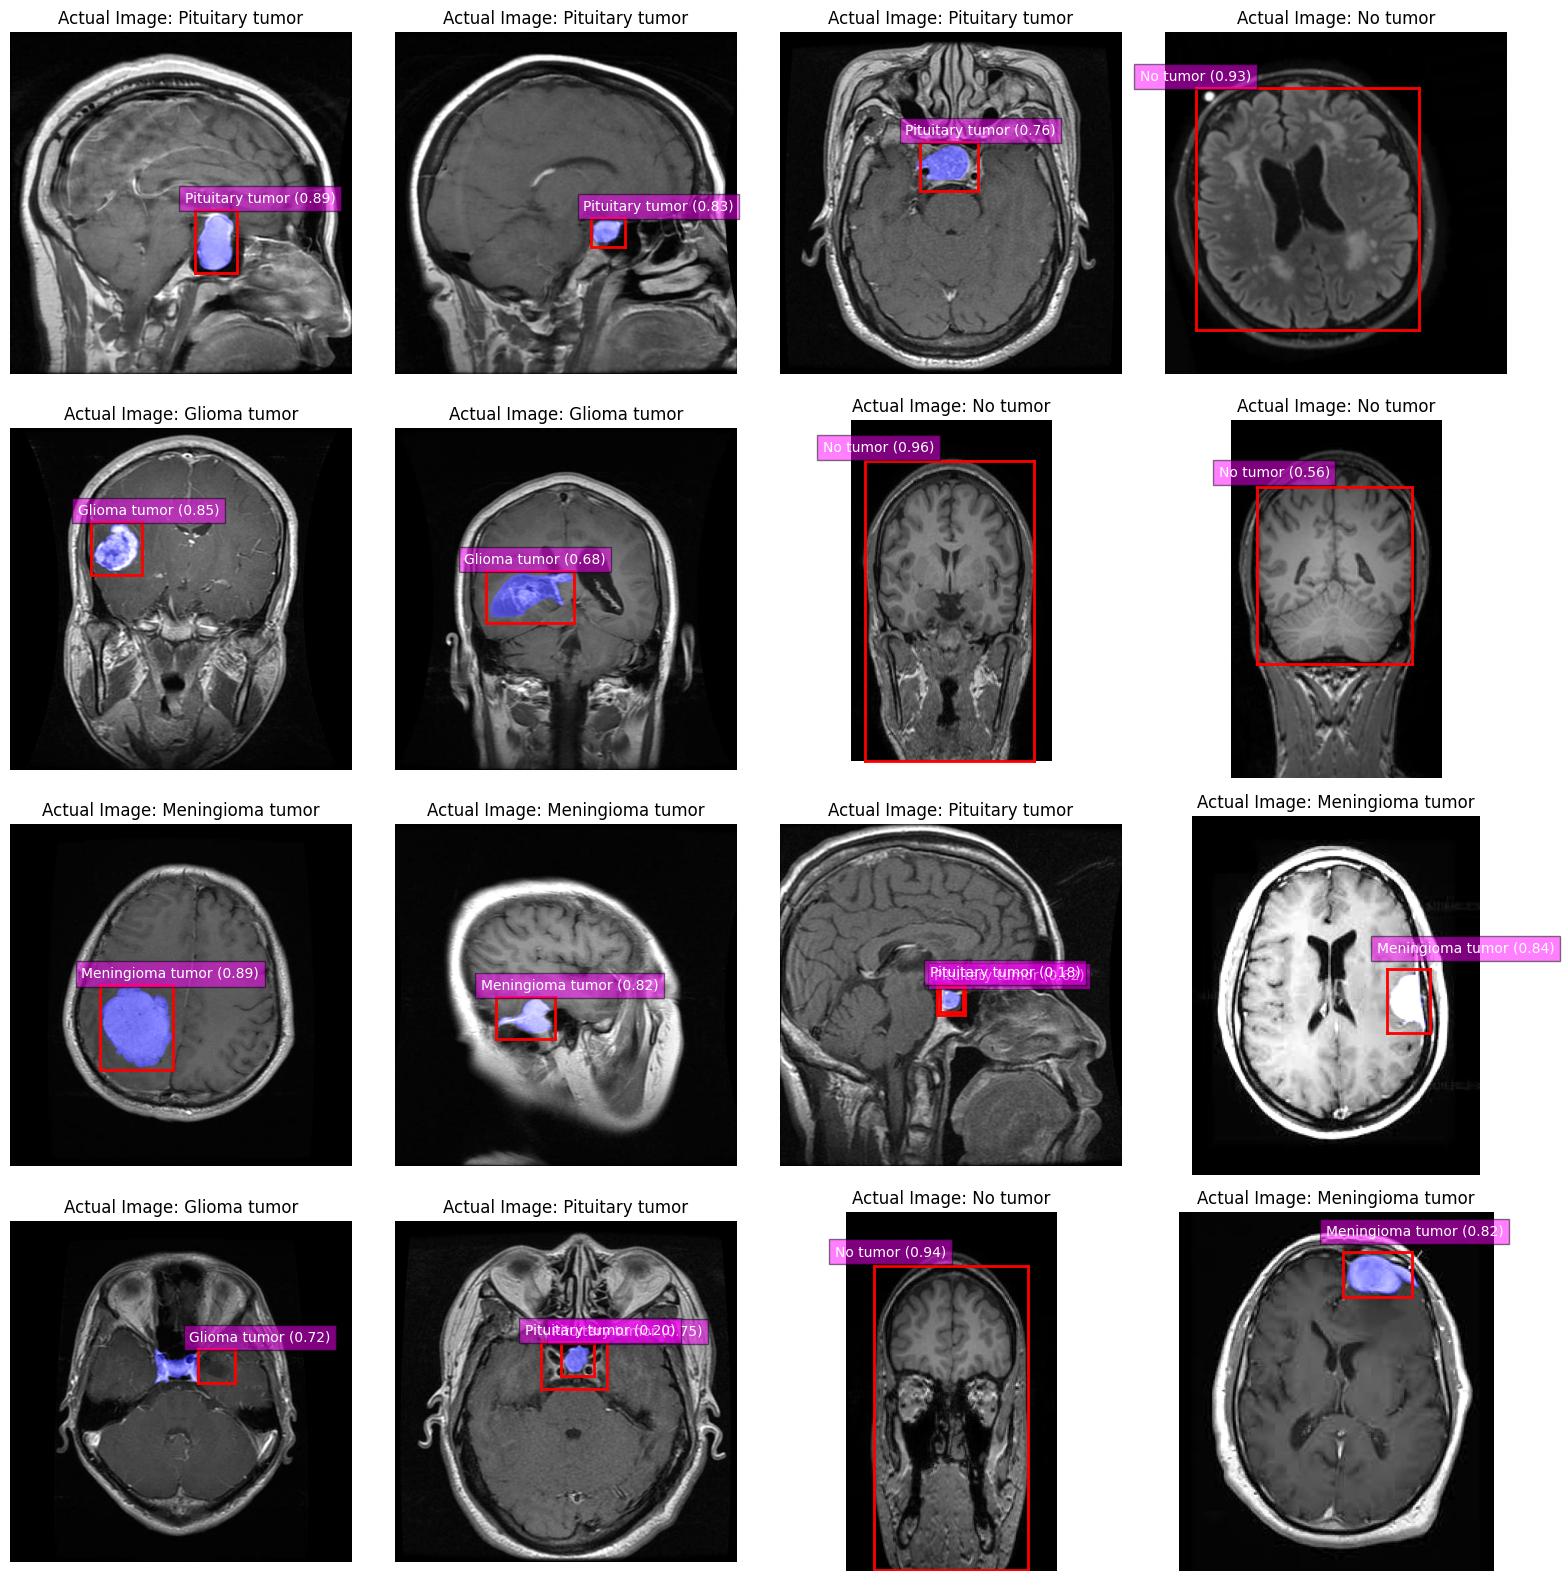

In [ ]:
# Run inference using the YOLOv12 model on a selected number of test images (with optional mask overlay)

predict_and_check(best_model_v12, image_path,
                        mask_path, 
                        start, 
                        stop,
                        mask=True)

In [9]:
# # Set the image directory path
# image_dir = image_path
# image_files = sorted([f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

# # Randomly sample 150 images without replacement
# selected_images = random.sample(image_files, 150)

# # Define video properties
# fps = 10
# frame_size = (512, 512)
# output_path = 'tumor_video.avi'
# video_writer = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'XVID'), fps, frame_size)

# # Write each image to the video
# for filename in selected_images:
#     img_path = os.path.join(image_dir, filename)
#     img = cv2.imread(img_path)

#     if img is None:
#         continue  # Skip unreadable images

#     # Resize to 512x512 if needed
#     if img.shape[:2] != (512, 512):
#         img = cv2.resize(img, frame_size)

#     # Convert grayscale to 3-channel if needed
#     if len(img.shape) == 2 or img.shape[2] == 1:
#         img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

#     video_writer.write(img)

# video_writer.release()
# print(f"Saved video to {output_path}")


Saved video to tumor_video.avi


In [ ]:
# Run inference on a video file using the YOLOv11 model, display results in real-time, and save the output

results = best_model_v11.predict(source='tumor_video.avi', show=True, save=True)
